# Superancillary functions

TODO: object hierarchy

TODO: rough description of algorithms

In [1]:
import json
import timeit
import functools 

import numpy as np 
import matplotlib.pyplot as plt

import ChebTools
import teqpflsh
import CoolProp.CoolProp as CP

Build a superancillary function for water

To begin, load from the provided files:

* $\rho'(T)$
* $\rho''(T)$
* $p(T)$

And then use the EOS (as implemented in CoolProp, but REFPROP would be fine too) to add

* $h'(T)$, $h''(T)$
* $s'(T)$, $s''(T)$
* $u'(T)$, $u''(T)$

In [2]:
j = json.load(open('superancillaryJSON/WATER_exps.json'))
sa = teqpflsh.SuperAncillary(json.dumps(j))

ca = sa.get_approx1d(k='D', q=0)
print('Water has non-monotonic rho\'(T). The monotonic intervals are:')
for inter in ca.monotonic_intervals:
    print(f'({inter.xmin}, {inter.xmax}) K')

Water has non-monotonic rho'(T). The monotonic intervals are:
(273.16, 277.15003423906836) K
(277.15003423906836, 647.0959999999867) K


In [3]:
AS = CP.AbstractState('HEOS', 'Water')
def calc(T, rho, AS, key):
    AS.specify_phase(CP.iphase_gas)
    AS.update(CP.DmolarT_INPUTS, rho, T)
    val = AS.keyed_output(key)
    AS.unspecify_phase()
    return val

# Add another thermodynamic variable to the superancillary
# Speed is order of ms per variable, likely MUCH faster in C++
# caller is a callable function that takes temperature and density and returns a value of a given property type
# here we can avoid flash calculations because we take T,rho value from the superancillary and 
# get values for the "other" variable
sa.add_variable(k='H', caller=functools.partial(calc, AS=AS, key=CP.iHmolar))
sa.add_variable(k='S', caller=functools.partial(calc, AS=AS, key=CP.iSmolar))
sa.add_variable(k='U', caller=functools.partial(calc, AS=AS, key=CP.iUmolar))

# Here is the call signature for the method
print(sa.add_variable.__doc__)

add_variable(self, *, k: str, caller: collections.abc.Callable[[float, float], float]) -> None


The monotonic intervals are:
(273.16, 277.15003423906836) K
(277.15003423906836, 647.0959999999867) K
T at extrema in rho(T): [277.15003423906836] K
and corresponding value 55504.316178396366 mol/m³


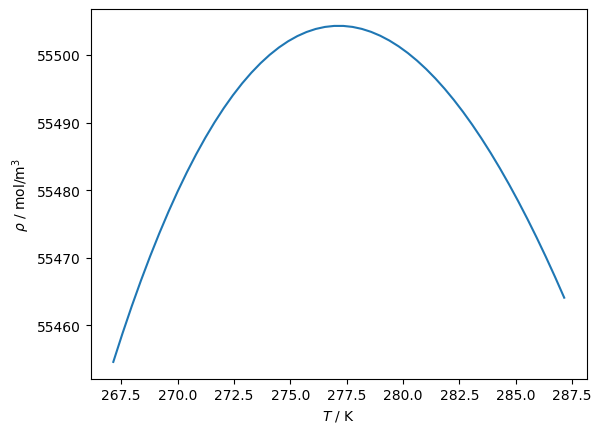

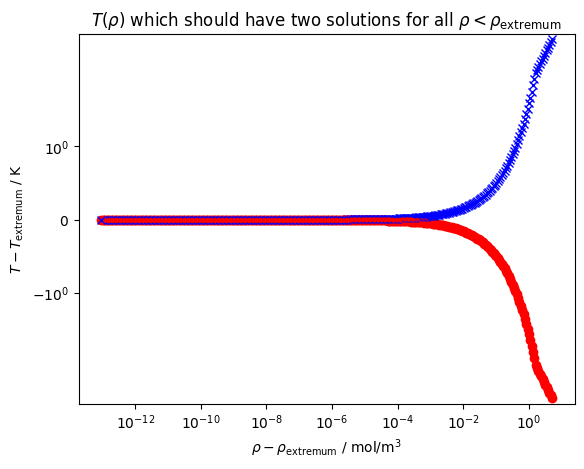

In [4]:
# Solving for temperature given saturated liquid density, around the density maximum
# as a challenging test for the rootfinding. The approach works well, even very close(!) 
# to the extremum

ca = sa.get_approx1d(k='D', q=0)
print('The monotonic intervals are:')
for inter in ca.monotonic_intervals:
    print(f'({inter.xmin}, {inter.xmax}) K')

print('T at extrema in rho(T):', ca.x_at_extrema, 'K')
print('and corresponding value', ca.eval(ca.x_at_extrema[0]), 'mol/m³')

plt.figure()
Trange = np.linspace(-10, 10) + ca.x_at_extrema[0]
plt.plot(Trange, [ca.eval(T) for T in Trange])
plt.gca().set(xlabel=r'$T$ / K', ylabel=r'$\rho$ / mol/m$^3$')

# Starting at a density below the extremum, test getting
# very close to the extremum and solving for temperature

plt.figure()
y_extremum = ca.eval(ca.x_at_extrema[0])
delta = y_extremum - 0.9999*y_extremum

while delta > 1e-13:
    # First output argument is the solution, second is the number of iterations required
    Tsoln = ca.get_x_for_y(y=y_extremum-delta)
    
    if len(Tsoln) != 2:
        break
    if Tsoln[0][0] > Tsoln[1][0]:
        break
    
    delta /= 1.1
    plt.plot(delta, Tsoln[0][0]-ca.x_at_extrema[0], 'ro')
    plt.plot(delta, Tsoln[1][0]-ca.x_at_extrema[0], 'bx')
    
plt.xscale('log')
plt.yscale('symlog')
plt.gca().set(xlabel=r'$\rho-\rho_{\rm extremum}$ / mol/m$^3$', ylabel=r'$T-T_{\rm extremum}$ / K')
plt.title(r'$T(\rho)$ which should have two solutions for all $\rho < \rho_{\rm extremum}$')

plt.show()

In [5]:
# Time forward evalution of a chebyshev expansion
T = np.linspace(273.16, 290, 1000000)
ybuf = np.zeros_like(T)
tic = timeit.default_timer()
ca.eval_many(T, ybuf)
toc = timeit.default_timer()
print('rho(T) takes', (toc-tic)/len(T)*1e6, 'μs/call')

# Time the rootfinding in the superancillary
tic = timeit.default_timer()
ybuf = np.linspace(55400, 55503, 1000000)
xbuf = np.zeros_like(ybuf)
ca.count_x_for_y_many(ybuf, 64, 100, 1e-10, xbuf)
toc = timeit.default_timer()
print('T(rho) takes', (toc-tic)/len(xbuf)*1e6, 'μs/call')
print('so the inversion is much slower, and here there are two candidate regions, so it is again two times worse than normal fluids, which would be more like:')

tic = timeit.default_timer()
ybuf = np.linspace(20400, 20503, 1000000)
xbuf = np.zeros_like(ybuf)
ca.count_x_for_y_many(ybuf, 64, 100, 1e-10, xbuf)
toc = timeit.default_timer()
print('T(rho) takes', (toc-tic)/len(xbuf)*1e6, 'μs/call when there is only one solution')

rho(T) takes 0.019866999937221408 μs/call


T(rho) takes 0.682848250027746 μs/call
so the inversion is much slower, and here there are two candidate regions, so it is again two times worse than normal fluids, which would be more like:


T(rho) takes 0.48029937501996756 μs/call when there is only one solution


Rootfinding is based on the TOMS748 method, which is an advanced version of the Brent method that is bounded and uses the optimal combination of secant, quadratic, and cubic interpolation mixed with bisection.

In [6]:
T_K, steps = ca.get_x_for_y(y=20250)[0]
print(f'{steps} iterations were required')

7 iterations were required


which is about that much higher than the forward evaluation of a superancillary itself

0.005620541982352734 μs/call


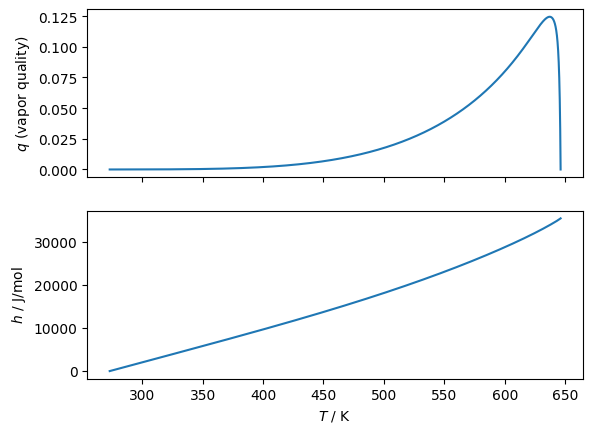

In [7]:
ca = sa.get_approx1d(k='D', q=0)
rhoc = ca.monotonic_intervals[1].ymin

# Pick a density where there is only one possible solution for temperature
for D in [22082.571366851185]:

    # Get the saturation temperature, if possible
    Tlims = [_ for _ in ca.get_x_for_y(y=D)]
    if len(Tlims) == 1:
        Trange = [ca.expansions[0].xmin, Tlims[0][0]]
    else:
        Trange = [Tlims[0][0], Tlims[1][0]]
        
    Ts = np.linspace(*Trange, 100000)
    # Non-iteratively solve for q for value of density
    q = np.array([sa.get_vaporquality(T=T_, propval=D, k='D') for T_ in Ts])

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    # And then plot another property
    y = np.zeros_like(q)
    tic = timeit.default_timer()
    sa.get_yval_many(q=q, T=Ts, k='H', y=y)
    toc = timeit.default_timer()
    print((toc-tic)/len(T)*1e6, 'μs/call')
    ax1.plot(Ts, q,)
    ax2.plot(Ts, y, label=D)
    ax1.set(ylabel='$q$ (vapor quality)')
    ax2.set(xlabel='$T$ / K', ylabel='$h$ / J/mol')

Plot lines of constant quality in the two-phase region according to the superancillary functions

0.2694700808656397 17873.7282300601 [(437.3594696512889, 10)]
1.4770892448723316 μs/call from 5.32 steps on average
1.934170722961426 μs/call from 8.17 steps on average
2.1833402570337057 μs/call from 9.6 steps on average
2.2904109209775925 μs/call from 10.12 steps on average
2.4208298418670893 μs/call from 10.27 steps on average
2.405830891802907 μs/call from 10.58 steps on average
2.394589828327298 μs/call from 10.59 steps on average
2.419160446152091 μs/call from 10.79 steps on average
2.353750169277191 μs/call from 10.46 steps on average
2.892089542001486 μs/call from 9.92 steps on average
1.397499581798911 μs/call from 5.25 steps on average
1.4008395373821259 μs/call from 5.32 steps on average
1.388750970363617 μs/call from 5.22 steps on average
1.3816705904901028 μs/call from 5.21 steps on average
1.4349992852658033 μs/call from 5.22 steps on average
1.4091597404330969 μs/call from 5.27 steps on average
1.3824994675815105 μs/call from 5.27 steps on average
1.4100002590566874 μs/c

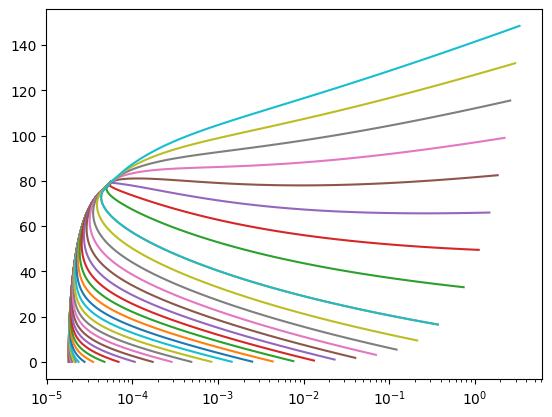

In [8]:
caV = sa.get_approx1d(k='D', q=1)
# for interval in caV.monotonic_intervals:
#     print(interval)
#     print({k: getattr(interval,k) for k in dir(interval) if not k.startswith('__')})
#     for m in interval.expansioninfo:
#         print({k: getattr(m,k) for k in dir(m) if not k.startswith('__')})
#         print(m.xmin, m.xmax)
print(caV.eval(273.16), caV.eval(647.096), caV.get_x_for_y(y=200))

# print([0].ymin, caV.monotonic_intervals[0].ymax)
# print(caV.get_x_for_y(y=200))

ca = sa.get_approx1d(k='D', q=0)
y = ca.eval(ca.x_at_extrema[0])*0.9999
Tlims = [_[0] for _ in ca.get_x_for_y(y=y)]

Ts = np.linspace(ca.expansions[0].xmin+1e-6, ca.expansions[-1].xmax-1e-6, 100)
# Ts = np.linspace(273.1600001, 280, 10000)

for Q in np.arange(1e-6, 1.0000, 0.1, dtype=float).tolist() + np.logspace(-8, -1, 30).tolist():
    Qs = Q*np.ones_like(Ts)
    
    rho = np.zeros_like(Ts)
    sa.get_yval_many(T=Ts, q=Qs, k='D', y=rho)
    
    other = np.zeros_like(Ts)
    kother = 'S'
    sa.get_yval_many(T=Ts, q=Qs, k=kother, y=other)
    plt.plot(1/rho, other)
    
    Tbuf = np.zeros_like(Ts)
    qbuf = np.zeros_like(Ts)
    countbuf = np.zeros_like(Ts)
    tic = timeit.default_timer()
    sa.solve_for_Tq_DX_many(rho, other, kother, 64, 100, 1e-10, Tbuf, qbuf, countbuf)
    toc = timeit.default_timer()
    print((toc-tic)/len(Tbuf)*1e6, 'μs/call from', np.mean(countbuf), 'steps on average')
    
    for T_goal_, rho_, other_ in zip(Ts, rho, other):
        soln = sa.solve_for_Tq_DX(rho_, other_, kother, 64, 100, 1e-10)
        try:
            T_ = soln.T; q_ = soln.q; count_ = soln.counter
        except BaseException as be:
            print(rho_, other_)
            print(be, T_goal_, Q)
            plt.plot(1/rho_, other_, 'o')
    
# plt.yscale('log')
plt.xscale('log')